In [10]:
import matplotlib.pyplot as plt
import netCDF4
import os, glob
import numpy as np
from scipy.interpolate import griddata
import h5py

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [11]:
CMROOT = r"C:\Users\axt5780\OneDrive - The Pennsylvania State University\PIML_project\IMERG_vectors"
nc_files = glob.glob(os.path.join(CMROOT, "*.nc"))

all_data = []
for nc_file in nc_files:
    channel_vec = netCDF4.Dataset(nc_file)
    data = channel_vec['pmmhr'][:, :]
    
    if np.isnan(data).any():
        valid_mask = ~np.isnan(data)
        nan_mask = np.isnan(data)  
        
        x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
      
        interpolated_data = griddata(
              points=(x[valid_mask], y[valid_mask]),
              values=data[valid_mask],
              xi=(x[nan_mask], y[nan_mask]),
              method='linear'
        )
        
        data[nan_mask] = interpolated_data
        
    all_data.append(data)
    channel_vec.close()
    
train = np.concatenate(all_data, axis=0)

print("Combined data shape:", train.shape)

Combined data shape: (17520, 39125)


In [12]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [28]:
shape = train.shape[1:]
latent_dim = 64

In [29]:
autoencoder = Autoencoder(latent_dim, shape)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(train, train,
              epochs=100,
          shuffle=True)

Epoch 1/100
548/548 [==============================] - 5s 8ms/step - loss: 0.3770
Epoch 2/100
548/548 [==============================] - 4s 8ms/step - loss: 0.3442
Epoch 3/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3355
Epoch 4/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3326
Epoch 5/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3312
Epoch 6/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3303
Epoch 7/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3296
Epoch 8/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3289
Epoch 9/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3285
Epoch 10/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3281
Epoch 11/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3278
Epoch 12/100
548/548 [==============================] - 4s 7ms/step - loss: 0.3275
Epoch 13/100


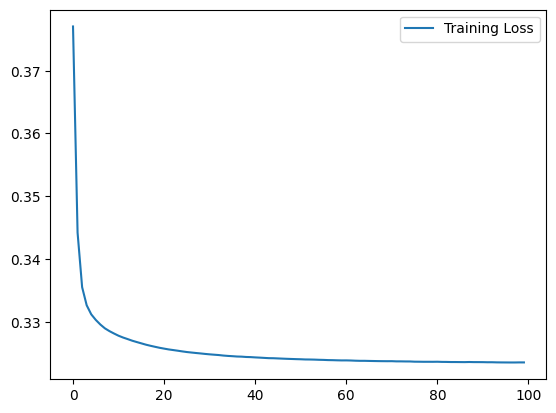

In [30]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [31]:
autoencoder.save_weights(f'weights/IMERG_{latent_dim}_downsample.h5')
print("Weights saved successfully.")

Weights saved successfully.


## REOPENING THE MODEL WITH WEIGHTS

In [32]:
autoencoder = Autoencoder(latent_dim, shape) 
autoencoder.load_weights(f'weights/IMERG_{latent_dim}_downsample.h5')

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.